In [ ]:
# Setting up the Colab environment. DO NOT EDIT!
try:
  from applied_biostats import setup_environment
except ImportError:
  !pip -q install applied-biostats-helper
  from applied_biostats import setup_environment
finally:
  grader = setup_environment('Module08_walkthrough')

# Walkthrough

## Learning Objectives
At the end of this learning activity you will be able to: 
 - Relate the null-hypotheses of chi2 tests, t-tests, ANOVAs, and Krustal-Wallace H-tests.
 - Calculate cross-tabulations of two categorical variables using `pd.crosstab`.
 - Employ `pg.chi2_independence` to estimate the correlation between two categorical variables.
 - Describe how to test if a distribution is normally distributed using multiple methods.
 - Employ `pg.ttest`, `pg.anova`, and `pg.kruskal` to look for differences in a dependent variable between different categorical variables.
 - Utilize post-hoc tests to refine the answer of an ANOVA.

## Introduction

As we discussed with Dr. Devlin in the introduction video, this week and next we are going to look at HIV neurocognitive impairment data from a cohort here at Drexel.
Each patient was given a full-scale neuropsychological exam and the resulting values were aggregated and normalized into Z-scores based on demographically matched healthy individuals.

In this walkthrough we will explore the demographic variables within this dataset to practice different types of hypothesis testing.
In the lab you will dive deeper and explore the effects of antiretroviral medications on neurological impairment.
In this cohort, we have two major drug regimens, d4T (Stavudine) and the newer Emtricitabine/tenofovir (Truvada).
The older Stavudine is suspected to have neurotoxic effects that are not found in the newer Truvada.
We will use inferential statistics to understand this effect.

## Hypothesis Testing

Hypothesis testing is a type of inferential statistics in which one compares a distribution to a previously assumed _null_ model that represents the _simplest_ explanation of the world.
The process of the test then involves rigorously evaluating the likelihood of observing this dataset under that _null_ assumption.
If, after rigorous evaluation, we find that the likelihood of generating this dataset under null model is below some threshold (ie p<0.05) we _reject_ the null hypothesis and accept the alternative.

While one can test arbitrarily complicated hypotheses, in biology we tend to fall back on a few go-to tests:
 * 2-factor tests (chi2-tests)
 * Tests of means (t-tests, ANOVAs, etc.)
 * Correlations (linear regression)

We'll cover the first two this week, and the last next week.

When boiled down, all of these tests rigorously balance four things:
 * Effect size : How large is _difference observed_ divided by the _spread of the observations_.
 * Type 1 Error (false-positives, p-value) : The likelihood of incorrectly _rejecting_ the null hypothesis.
 * Type 2 Error (false-negatives, power) : The likelihood of incorrectly _accepting_ the null hypothesis.
 * Number of observations.

## Pingouin

The `pingouin` Python package is a statistical tool designed to bridge the gap between the data manipulation capabilities of pandas and the visualization strengths of seaborn, with a specific focus on ease of use and accessibility.
It is particularly tailored towards researchers who are embarking on their journey into data exploration and biostatistics, leveraging their familiarity with pandas for data manipulation and seaborn for data visualization.

`pingouin` is built on top of pandas `DataFrame` objects, which means that it integrates seamlessly with the pandas ecosystem.
This allows users to effortlessly prepare their data using pandas and then apply statistical tests and models using pingouin.
The package offers a wide range of statistical functions, including t-tests, ANOVAs, correlation tests, and regression analyses, with a syntax that is more intuitive and less verbose than some of its counterparts.
This makes pingouin an attractive option for biologists who may not have a deep background in statistics but need to conduct sophisticated statistical analyses as part of their research.

Two other popular packages for statistical analysis in python are `scipy.stats` and `statsmodels`.
Scipy offers many low-level functions for calculating basic statistical tests like t-tests, ANOVAs, Mann-Whitney, etc.
However, these low level functions require extensive programming knowledge to leverage properly.

Statsmodels offers a wealth of complex statistical modeling, p-value correction tools, and allows arbitrarily complicated regression analysis.
However, due to its complexity, it is not approachable for beginners.

Under the hood, Pingouin employs `scipy.stats`, `statsmodels`, and a number of other tools into a simple and intuitive API designed to be user-friendly and accessible.
The outputs it creates are interpretable at a glance and contain outputs from a number of lower-level tools.
This is intended to make it easier to apply statistical tests and interpret their results without getting bogged down in the complexities of statistical theory.
Additionally, pingouin is designed to work well with Pandas and the Jupyter Notebook environment, which is popular among scientists for interactive data analysis.

Check out the documentation for [Pingouin](https://pingouin-stats.org/build/html/index.html).
 - [Quick Start Examples](https://pingouin-stats.org/build/html/index.html#quick-start)
 - [Available tests](https://pingouin-stats.org/build/html/api.html)
 - [Which test to pick](https://pingouin-stats.org/build/html/guidelines.html)

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import pingouin as pg

%matplotlib inline

In [3]:
data = pd.read_csv('hiv_neuro_data.csv')
data['education'] = data['education'].astype(float)
data.head()

,sex,age,education,race,processing_domain_z,exec_domain_z,language_domain_z,visuospatial_domain_z,learningmemory_domain_z,motor_domain_z,ART,YearsSeropositive
0,male,62,10.0,AA,0.5,0.6,0.151646,-1.0,-1.152131,-1.364306,Stavudine,13
1,male,56,10.0,AA,-0.5,1.2,-0.255505,-2.0,-0.086376,-0.348600,Truvada,19
2,female,51,10.0,AA,0.5,0.1,0.902004,-0.4,-1.139892,0.112215,Stavudine,9
3,female,47,12.0,AA,-0.6,-1.2,-0.119866,-2.1,0.803619,-2.276768,Truvada,24
4,male,46,13.0,AA,-0.4,1.3,0.079129,-1.3,-0.533607,-0.330541,Truvada,14


When studying HIV Associated Neurocognitive Disorder (HAND) we measure a number of cognitive domains through a ~90 min test battery.
The results of these tests are then aggregated into 6 cognitive domains.

- **Speed of Information Processing** : `processing_domain_z` : How quickly an individual can understand and react to the information being presented. This domain evaluates the speed at which cognitive tasks can be performed, often under time constraints.
 - **Learning and Memory** : `learningmemory_domain_z` : This involves both the acquisition of new information (learning) and the ability to retrieve this information over time (memory). It includes both verbal learning and memory (e.g., remembering words or stories) and visual learning and memory (e.g., remembering shapes or patterns).
 - **Executive Function** : `exec_domain_z` : The complex cognitive processes required for planning, organizing, problem-solving, abstract thinking, and executing strategies. This domain also encompasses decision-making and cognitive flexibility, which is the ability to switch between thinking about two different concepts or to think about multiple concepts simultaneously.
 -  **Motor Skills** : `motor_domain_z` :  This domain assesses the coordination, speed, and dexterity of motor movements, including both fine motor skills (e.g., hand movements, writing) and gross motor skills (e.g., walking, coordination).
 - **Language Skills** : `language_domain_z` : The ability to understand and produce language. While not always as prominently affected in HAND as other cognitive domains, assessments might include naming, fluency, and comprehension tasks.
 - **Sensory-Perceptual Skills** : `visuospatial_domain_z` : Although less commonly assessed in HAND research, this domain involves the ability to interpret sensory information, including visual and auditory processing.

The outcomes of these test are highly correlated with age, sex, race, and education.
This makes it difficult to compare the raw results of a test between individuals across these covariates; ie. 
is this 65 year old performing worse on a memory task relative to a 25 year old because of their _age_ or because of some type of _impairement_?
With the raw scores alone, this is impossible.

However, if we collect data from a large number of _presumably_ healthy individuals we can create a normalization scale.
These are normalized to a **Z-scale**. 
In a z-scaled value, `z = 0` is the mean; all individuals performing at the average of covariate matched controls will have a score of 0.
Each unit of a z-scale is 1-standard-deviation.
An individual with a `z = 1` is performing 1 standard-deviation _above_ thier peers while a `z = -1.5` implies that they are performing 1.5 stds _below_ their matched peers.

You've probably heard of this before: an _IQ score_ works in a similar way.
It uses a **standard scale**. This has a mean of 100 and a standard deviation of 10. 
An _average_ IQ is 100 (by definition).
An IQ of 210 (Marylin vos Savant) is 11 standard-deviations above an _average_ individual.

## Categorical comparisons

### Q1: Count the number of participants of each sex and race.

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 4  |

In [4]:
q1_race_counts = data['race'].value_counts() # SOLUTION
q1_sex_counts = data['sex'].value_counts() # SOLUTION

In [5]:
print(f'q1_race_counts is a `Series`: {isinstance(q1_race_counts, pd.Series)}')

q1_race_counts is a `Series`: True


In [6]:
print(f'q1_sex_counts is a `Series`: {isinstance(q1_sex_counts, pd.Series)}')

q1_sex_counts is a `Series`: True


In [7]:
print(f"q1_race_counts: {q1_race_counts[['AA', 'C', 'H']]}")

q1_race_counts: race
AA    220
C      74
H      31
Name: count, dtype: int64


In [8]:
print(f"q1_sex_counts: {q1_sex_counts[['male', 'female']]}")

q1_sex_counts: sex
male      225
female    100
Name: count, dtype: int64


Once we have the counts, we can change each into a probability.
This represents the likelihood of observing any given instance of the categorical variable.
We can think of this like an _unfiar_ set of dice.

In [9]:
q1_race_counts/q1_race_counts.sum()

race
AA    0.676923
C     0.227692
H     0.095385
Name: count, dtype: float64

In [10]:
q1_sex_counts/q1_sex_counts.sum()

sex
male      0.692308
female    0.307692
Name: count, dtype: float64

Let's do the same thing for the ART column.

In [11]:
art_counts = data['ART'].value_counts()
art_counts/art_counts.sum()

ART
Stavudine    0.52
Truvada      0.48
Name: count, dtype: float64

I wonder if there is a relationship between demographic variables and ART therapy?

That was looking at each measurement individually, if we want to know whether they are correlated, we need a different type of table.
We need a table that measures the number of occurances of `male & Stavudine`, `female & Stavudine`, `male & Truvada`, `female & Truvada`, etc.
This is often called a _cross tabulation_.
_Traditionally_ one would use a set of `for`-loops to count this data, but Pandas has a tool for exactly this purpose.

In [12]:
pd.crosstab(data['sex'], data['ART'], margins=True)

ART,Stavudine,Truvada,All
sex,,,
female,53,47,100
male,116,109,225
All,169,156,325


It can also give us frequencies.

In [13]:
pd.crosstab(data['race'], data['ART'], margins=True, normalize='all')

ART,Stavudine,Truvada,All
race,,,
AA,0.313846,0.363077,0.676923
C,0.153846,0.073846,0.227692
H,0.052308,0.043077,0.095385
All,0.520000,0.480000,1.000000


## Hypothesis Testing

When testing the correlation between two _categorical_ variables we want to use a `chi2` test.
It has the _null hypothesis_ that the two categorical distributions are uncorrelated.
Rejection of that hypothesis (ie p<0.05) indicates there is some linkage between the two distributions.

Notes:

In your cross tabulation table you need _at least_ 5 observations in each cell.
Fewer than that can lead to significant losses in statistical power.

When we want to visualize a categorical comparison, it is best to use a countplot that uses both `x` and `hue` to show the two factors.
If there is a difference, we will see that the bars have inconsistent _relative_ heights when compared to each other.

<Axes: xlabel='sex', ylabel='count'>

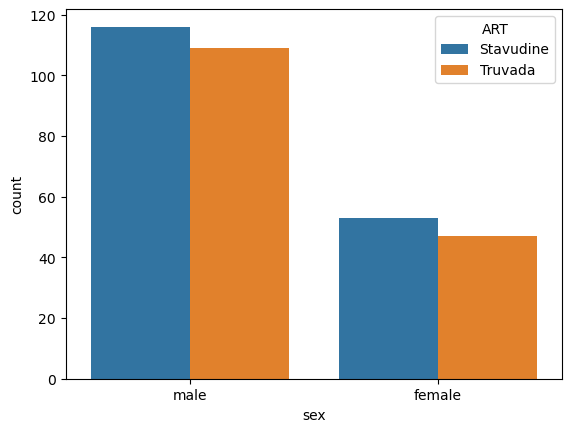

In [14]:
sns.countplot(data = data,
              x = 'sex',
              hue = 'ART')

Pingouin has a function for performing a chi2 test from a `pd.Dataframe` directly: [`pg.chi2_independence`](https://pingouin-stats.org/build/html/generated/pingouin.chi2_independence.html).
It will return three things:

In [15]:
# Pingouin does the crosstab internally, it just wants the df and columns

expected, obs_cor, stats = pg.chi2_independence(data, 'sex', 'ART')

If these two variables were randomly associated, what would I have gotten?

In [16]:
expected

ART,Stavudine,Truvada
sex,,
female,52.0,48.0
male,117.0,108.0


What did I actually observe after correction?

In [17]:
obs_cor

ART,Stavudine,Truvada
sex,,
female,52.5,47.5
male,116.5,108.5


What is the likelihood that `obs_cor` is different from `expected`?

In [18]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.014468,1.0,0.904260,0.006672,0.051659
1,cressie-read,0.666667,0.014468,1.0,0.904258,0.006672,0.051659
2,log-likelihood,0.000000,0.014470,1.0,0.904253,0.006673,0.051659
3,freeman-tukey,-0.500000,0.014471,1.0,0.904249,0.006673,0.051659
4,mod-log-likelihood,-1.000000,0.014472,1.0,0.904244,0.006673,0.051659
5,neyman,-2.000000,0.014475,1.0,0.904235,0.006674,0.051660


`p ~= 0.9`, therefore we cannot reject the hypothesis that ART therapy is unrelated to sex.

### Q2: Is race and education correlated in this dataset?

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 4  |

In [19]:
# Bin education into three bins:
#  * Up to HS education (0, 12]
#  * HS-4yr College (12, 16]
#  * >4yr College (16, np.inf]
# pandas has a function pd.cut that that accomplish this.

# Add this column back into the dataframe as a new column called `education_binned`
data['education_binned'] = pd.cut(data['education'], [0, 12, 16, np.inf])

In [20]:
# Calculate the chi2 test between race and education_binned
q2_expected, q2_obs_cor, q2_stats = pg.chi2_independence(data, 'race', 'education_binned') # SOLUTION NO PROMPT

In [21]:
# Is race and education correlated? (yes or no)
q2_pval_ans = 'yes' # SOLUTION

In [22]:
# Are there "more" or "less" H's with 12-16 years of education than we'd expect by chance
q2_inter_ans = 'less' # SOLUTION

In [23]:
print(f'q2_pval_ans is a `str`: {isinstance(q2_pval_ans, str)}')

q2_pval_ans is a `str`: True


In [24]:
print(f'q2_pval_ans =', q2_pval_ans)

q2_pval_ans = yes


In [25]:
print(f'q2_inter_ans is a `str`: {isinstance(q2_inter_ans, str)}')

q2_inter_ans is a `str`: True


In [26]:
print(f'q2_inter_ans =', q2_inter_ans)

q2_inter_ans = less


So, we found that there is a link between race and education, with AA and H individuals have less people in the higher education brackets and more in the lower education brackets.

In this instance we used stratification to split education into categorical variables representing meaningful cutoffs.
We can also keep the education value as a continious measurement and compare across categories.

## Continious comparisons

In order to choose the right test we need to walk down a set of decision trees to find the appropriate answer.
There are a number of places you can find these decision trees (or you can make your own), we'll use the one from the pingouin tool.

https://pingouin-stats.org/build/html/guidelines.html

The first thing to test: _normality_.

If the variable is normally distributed (or can be approximated as normal) we can use more powerful parametric tests. If it is not normal, we need to use non-parametric tests.

A `qqplot` is a common way to visualize the fit between an observed distribution and a theoretical one.
It plots the observed data against a desired distribution (usaually the normal distribution).
If there is strong agreement, it likely means the data fits the distribution.
It is the best place to start when starting considering normality.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

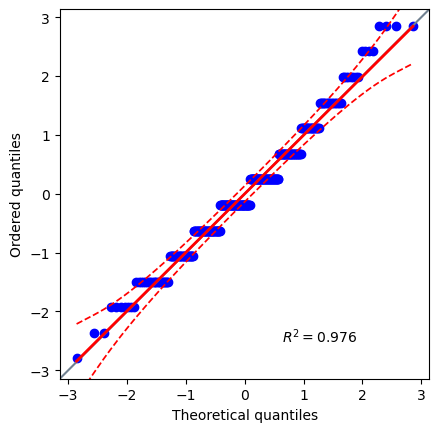

In [27]:
pg.qqplot(data['education'], dist='norm')

Extremely high agreement. I would expect this to be normally distributed. Let's use Pingouin to test it.

In [28]:
# Tests the null-hypothesis: is this derived from a normal distribution
# with the default parameters

pg.normality(data['education'])

,W,pval,normal
education,0.975734,0.000027,False


Interesting, it rejected the hypothesis that this data is normally distributed.
This is why you _NEED_ to have documentation open when utilizing these tools.

https://pingouin-stats.org/build/html/generated/pingouin.normality.html

> method: str
> Normality test.
> * ‘shapiro’ (default) performs the Shapiro-Wilk test using scipy.stats.shapiro(),
> * ‘normaltest’ performs the omnibus test of normality using scipy.stats.normaltest(),
> * ‘jarque_bera’ performs the Jarque-Bera test using scipy.stats.jarque_bera().
>
> **The Omnibus and Jarque-Bera tests are more suitable than the Shapiro test for large samples.**


In [29]:
pg.normality(data['education'], method='normaltest')

,W,pval,normal
education,5.843312,0.053844,True


In [30]:
pg.normality(data['education'], method='jarque_bera')

,W,pval,normal
education,5.585359,0.061257,True


Now we see that both of these methods, and the qq-plot agree that this data is normally disitributed.

### Two group measurement

<Axes: xlabel='sex', ylabel='education'>

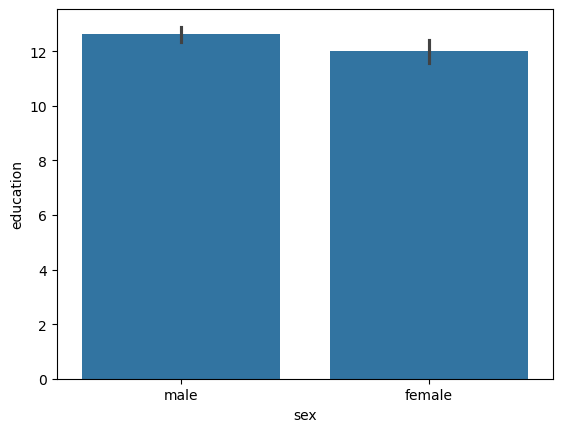

In [31]:
sns.barplot(data = data,
            x = 'sex',
            y = 'education')

Handy-dandy t-test.
Measures the null-hypothesis:
 * One-sample: Does this sample have a mean of _mu_?
 * Two-sample (independent): Do these two distribution have the _mean_ value?
 * Two-sample (paired): Do these pre/post measurements of the **same** sample have the same _mean_ value?

In [32]:
male_edu = data.query('sex == "male"')['education']
female_edu = data.query('sex == "female"')['education']
pg.ttest(male_edu, female_edu)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.245961,202.108089,two-sided,0.025789,"[0.07, 1.13]",0.263056,1.438,0.587972


Breaking this down:
 * `T = 2.245961` : Called the T-statistic : (mean_M-mean_F)/std_P*sqrt(1/N_m+1/N_f)
 * `dof = 202.1` : The number of samples after dropping missing and applying corrections.
 * `alternative = two-sided` : The mean of females can be larger _or_ smaller than males.
 * `p-val = 0.025` : The likelihood of seeing this difference by chance.
 * `CI95% = [0.07, 1.13]` : The difference in means between males and females is between 0.7 and 1.13 years.
 * `cohen-d = 0.26` : The effect size : (mean_M-mean_F)/std_P
 * `BF10 = 1.43` : Bayes Factor : P(D|H1)/P(D|H0) : The likelihood of the data given the alternative hypothesis divided by the likelihood of the data under the null hypothesis.
 * `power = 0.587` : The likelihood of see an effect if there truly was one given cohen-D and dof.

### Multi-group measurement

<Axes: xlabel='race', ylabel='education'>

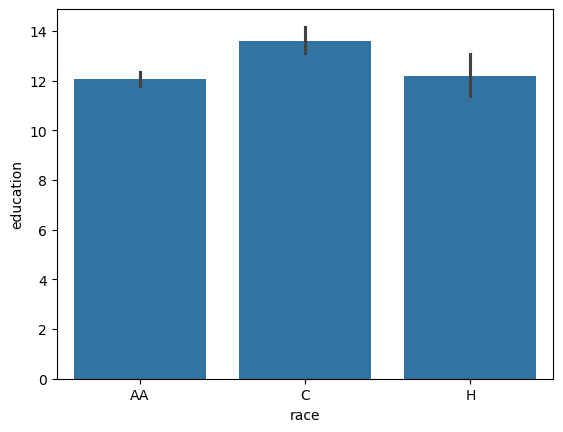

In [33]:
sns.barplot(data = data,
            x = 'race',
            y = 'education')

Handy-dandy One-way ANOVA with post-hoc tests.

https://pingouin-stats.org/build/html/guidelines.html#anova

In [34]:
# First test for equal variances to pick correct ANOVA

pg.homoscedasticity(data, dv='education', group='race')

,W,pval,equal_var
levene,1.292877,0.275901,True


In [35]:
pg.anova(data, dv='education', between='race', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,race,131.796715,2,65.898357,13.37776,0.000003,0.076717
1,Within,1586.160208,322,4.925963,NaN,NaN,NaN


Here the ANOVA rejects the hypothesis that the mean is the same across races.
However, it does not tell us *which* ones are different.
That's where post-hoc testing comes in.
Since we have equal-varainces across the group, it suggets Tukey's post hoc test.

In [36]:
pg.pairwise_tukey(data=data, dv='education', between='race')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,AA,C,12.077273,13.608108,-1.530835,0.298258,-5.132588,0.000001,-0.697499
1,AA,H,12.077273,12.193548,-0.116276,0.425785,-0.273085,0.959729,-0.054118
2,C,H,13.608108,12.193548,1.414560,0.474836,2.979050,0.008714,0.567577


This provided a table with a row for each comparison.
`p-tukey` indicates the rows with significant differences.

We can also do Multi-way ANOVAs; this is where you have more than one independent variable splitting your data.
Here, we can look at how both *race* **and** *gender* impact educational attainment.

<Axes: xlabel='race', ylabel='education'>

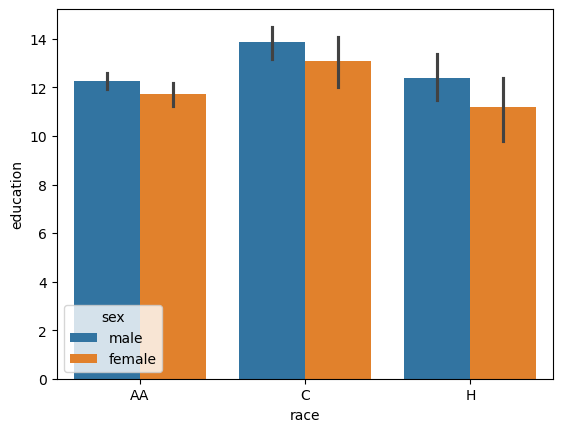

In [37]:
sns.barplot(data = data,
            x = 'race',
            hue = 'sex',
            y = 'education')

In [38]:
pg.anova(data, dv='education', between=['race', 'sex'], detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,race,133.744087,2.0,66.872043,13.700951,0.000002,0.079104
1,sex,27.055406,1.0,27.055406,5.543195,0.019158,0.017080
2,race * sex,2.119345,2.0,1.059672,0.217109,0.804961,0.001359
3,Residual,1556.985457,319.0,4.880832,NaN,NaN,NaN


This tells us that there is likely a difference between race, between sex, but there likely isn't an interactive term.
We can also do the post-hoc tests across all comparisons.

In [39]:
results = pg.pairwise_tests(data=data, dv='education', between=['race', 'sex'])
results

,Contrast,race,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,race,-,AA,C,False,True,-4.794172,110.376193,two-sided,0.000005,5562.177,-0.697499
1,race,-,AA,H,False,True,-0.247486,36.168163,two-sided,0.805932,0.209,-0.054118
2,race,-,C,H,False,True,2.658937,55.713740,two-sided,0.010214,4.718,0.567577
3,sex,-,female,male,False,True,-2.245961,202.108089,two-sided,0.025789,1.438,-0.262445
4,race * sex,AA,female,male,False,True,-1.826097,149.778935,two-sided,0.069827,0.739,-0.254068
5,race * sex,C,female,male,False,True,-1.230186,41.659681,two-sided,0.225529,0.481,-0.313088
6,race * sex,H,female,male,False,True,-1.322973,8.498605,two-sided,0.220332,0.753,-0.461862


In [40]:
results.loc[results['p-unc'] < 0.05]

,Contrast,race,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,race,-,AA,C,False,True,-4.794172,110.376193,two-sided,0.000005,5562.177,-0.697499
2,race,-,C,H,False,True,2.658937,55.713740,two-sided,0.010214,4.718,0.567577
3,sex,-,female,male,False,True,-2.245961,202.108089,two-sided,0.025789,1.438,-0.262445


If we had repeated measures for individuals (ie biological replicates) we can also add `, within = 'sample'`.
This would help correct for within sample variability.

### Non-parametric comparisons

### Q3: Use the appropriate non-parametric method.

Let's pretend that we believed the first Shapiro-Wilk normality test and instead used non-parametric methods.
Use the flowchart below to test the whether there is a difference in education level across `race`.

https://pingouin-stats.org/build/html/guidelines.html#non-parametric

![Non-parametric flow chart](https://pingouin-stats.org/build/html/_images/flowchart_nonparametric.svg)

|               |    |
| --------------|----|
| Points        | 5  |
| Public Checks | 4  |

In [41]:
# Use the appropriate test from the Guidelines
q3_stats = pg.kruskal(data, dv='education', between='race') # SOLUTION
q3_stats

,Source,ddof1,H,p-unc
Kruskal,race,2,22.498491,0.000013


In [42]:
# Use the appropriate post-hoc test from the Guidelines
q3_post_hoc = pg.pairwise_tests(data, dv='education', between='race', parametric=False) # SOLUTION
q3_post_hoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,race,AA,C,False,False,5199.0,two-sided,0.000003,-0.697499
1,race,AA,H,False,False,3482.0,two-sided,0.848419,-0.054118
2,race,C,H,False,False,1540.5,two-sided,0.005371,0.567577


Compare this answer to the parametric method.

In [43]:
# Are they the 'same' or 'different'

q3_comparison = 'same' # SOLUTION

In [44]:
print(f'q3_stats is a `DataFrame`: {isinstance(q3_stats, pd.DataFrame)}')

q3_stats is a `DataFrame`: True


In [45]:
print(f'q3_post_hoc is a `DataFrame`: {isinstance(q3_post_hoc, pd.DataFrame)}')

q3_post_hoc is a `DataFrame`: True


In [46]:
print(f'q3_post_hoc is a `str`: {isinstance(q3_comparison, str)}')

q3_post_hoc is a `str`: True


In [47]:
print(f'q3_stats.loc["Kruskal", "H"] = {q3_stats.loc["Kruskal", "H"]:0.3f}')

q3_stats.loc["Kruskal", "H"] = 22.498


In [48]:
print(f'q3_post_hoc["Parametric"].any() = {q3_post_hoc["Parametric"].any()}')

q3_post_hoc["Parametric"].any() = False


We should see that we'll get the same answer between parametric and non-parametric methods.

We've now seen a handful of methods for testing the difference between populations.
In the lab, you will use these skills to test the effects of different ART drugs on neurocognitive impairment.

---------------------------------------------

## Submission

You do not need to submit this walkthrough notebook.
Simply complete the quiz.

In [49]:
grader.check_all()